![Astrofisica Computacional](../../logo.PNG)

---

Eduard Larrañaga (ealarranaga@unal.edu.co)

---

---

# Ejercicio 03. Ecuaciones Diferenciales Ordinarias I


## A. Movimiento de un Cometa 


Existen muchos cometas que orbitan alrededor del Sol con trayectorias elípticas. De acuerdo con las leyes de Kepler, cuando el cometa se encuentra lejos del centro de fuerza, su movimiento es lento, mientras que al acercarse al Sol su velocidad es bastante grande. Este es un sistema físico que claramente debería ser solucionado con un método de paso adaptativo: en la región lejana se pueden utilizar pasos grandes mientras que en la región cercana se necesitan pasos muy cortos para tener un error pequeño.

Utilizando coordenadas cartesianas en el plano de movimiento, la dinámica del cometa bajo la influencia Solar está descrito por las ecuaciones 
\begin{align}
    \frac{d^2x}{dt^2} = &-GM \frac{x}{r^3} \\
    \frac{d^2y}{dt^2} = &-GM \frac{y}{r^3}
\end{align}
donde $r = \sqrt{x^2 + y^2}$, $G$ es la constante gravitacional de Newton y $M$ es la masa del Sol.

---

2. Ahora escriba un programa que resuelva el problema utilizando uno de los métodos RK con paso adaptativo. Establezca la tolerancia de tal forma que se tenga una precisión de $1 \text{ km}$ por año en la posición del cometa. Como se comparan los resultadosde los dos métodos?
    Realice un gráfico de $x$ vs. $t$ y otro de $y$ vs. $t$ localizando los puntos correspondientes a los calculos con paso adaptativo para confirmar que el tamaño cambia de acuerdo a la ubicación del cometa con respecto al Sol.

---
**Solución**

Al igual que en el punto anterior, utilizaremos un sistema de unidades adecuado para describir el Sistema Solar así:

- unidad de masa: masa Solar $[M_{\odot }]$
- unidad distancia: Unidad Astronómica [au]
- unidad de tiempo: años [yr]

Utilizando este sistema de unidades, la constante gravitacional de Newton tendrá un valor de $G = 4\pi^2$,

De esta forma, implementaremos ua función llamada `f` que retornará el lado derecho de las ecuaciones diferenciales de movimiento y una función denominada `conserv_quant` que calculas las cantidades conservadas del problema (energía y momento angular).

In [1]:
import numpy as np

# Newtonian Gravitational Constant
G = 4.*np.pi**2
M = 1.

def f(t0, q0):
    '''
    ------------------------------------------
    f(t0, q0) 
    ------------------------------------------
    ODEs system for the motion of a comet 
    around the Sun using cartesian coordinates
    in the orbital plane.
    ------------------------------------------
    Arguments:
    t0: initial time
    q0: numpy array with the initial condition
        data:
        q0[0] = x
        q0[1] = y
        q0[2] = dx/dt
        q0[3] = dy/dt
    ------------------------------------------
    Dependeces: NumPy
    ------------------------------------------
    '''
    f = np.zeros(4)
    f[0] = q0[2]
    f[1] = q0[3]
    f[2] = - G*M*q0[0]/(q0[0]**2 + q0[1]**2)**(3/2)
    f[3] = - G*M*q0[1]/(q0[0]**2 + q0[1]**2)**(3/2)
    return f

def conserv_quant(q):
    '''
    ------------------------------------------
    conserv_quant(q)
    ------------------------------------------
    Evaluates the total energy and the total 
    angular momentum for the system 
    ------------------------------------------
    Arguments:
    q: NumPy array with the state of the 
       system in the format
       q = [t, x, y, vx, vy]
    ------------------------------------------
    Returns:
    E : Total Energy
    L : Total Angular Momentum
    ------------------------------------------
    Dependeces: NumPy
    ------------------------------------------
    '''
    CQ = np.zeros([len(q),3])
    CQ[:,0] = q[:,0] 
    v2 = q[:,3]**2 + q[:,4]**2
    r = np.sqrt(q[:,1]**2 + q[:,2]**2)
    E = v2/2 - G*M/r
    L = q[:,1]*q[:,4] - q[:,2]*q[:,3]
    CQ[:,1] = E
    CQ[:,2] = L
    return CQ


**Condición Inicial**

Como establece el enunciado del ejercicio, se impondrán las siguientes condiciones iniciales:

\begin{equation}
        \begin{cases}
            x = &4 \times 10^9 \text{ km}\\
            y = &0 \text{ km}\\
            v^x = &0  \text{ m/s}\\
            v^y = &500 \text{ m/s}.
        \end{cases}
    \end{equation}
    
Transformamos esta información a las unidades establecidas arriba,

In [2]:
# Initial Conditions
x = 4e9 # [km]
y = 0 # [km]
vx = 0 # [m/s]
vy = 500 # [m/s]

# Conversion Factors
au2m = 1.496e11  # 1au in meters
yr2s = 3.154e7   # 1yr in seconds

# Transformation
x *= 1000/au2m # [au]
y *= 1000/au2m # [au]
vx *= yr2s/au2m # [au/yr]
vy *= yr2s/au2m # [au/yr]


x, vy

(26.737967914438503, 0.10541443850267379)

## Solución del sistema ODEs

Definiremos la función que utilizará el método RK4 adaptativo, con un valor inicial de $dt=1\times 10^{-2}$. Se calculará la trayectoria desde $t_0 = 0$ años hasta $t_f = 300$ años. Para evitar. un calculo demasiado extenso, se impondra también un límite de $n$ nodos.

In [3]:
# Computation time
import time

# Adaptative Runge-Kutta 4 Algorithm
def ARK4(ODE, t0, q0, tf, n, dt = 1e-2, epsilon = 1e-8):
    '''
    ------------------------------------------
    RK4(ODE, t0, q0, tf, n, dt, epsilon)
    Adaptative 4th Order Runge-Kutta method 
    for solving a system of ODEs.
    ------------------------------------------
    Arguments:
    ODE: function defining the system of ODEs
    t0: independent parameter initial value
    q0: numpy array with the initial values of
        the functions in the ODEs system
    tf: independent parameter final value
    n: Max number of steps for the integration
    dt: Initial value of the stepsize
    epsilon: Tolerance of the adaptative 
             method
    ------------------------------------------
    Dependences: NumPy
    ------------------------------------------
    '''
    # Initial Condition
    q = np.zeros([n,len(q0)+1])
    q[0,0] = t0
    q[0,1:] = q0
    
    # k-functions for the RK4 algorithm
    def ks(qn,dt):
        k1 = dt*ODE(qn[0], qn[1:])
        k2 = dt*ODE(qn[0] + dt/2, qn[1:] + k1[:]/2)
        k3 = dt*ODE(qn[0] + dt/2, qn[1:] + k2[:]/2)
        k4 = dt*ODE(qn[0] + dt, qn[1:] + k3[:])
        return (k1 + 2*k2 + 2*k3 + k4)/6
    
    # time and index counters
    time = t0
    i = 1
    while i<n-1 and time<tf:
        # 2 steps with dt
        q[i,1:] = q[i-1,1:] + ks(q[i-1,:],dt)[:]
        q[i+1,1:] = q[i,1:] + ks(q[i,:],dt)[:]
        q1 = q[i+1,1:]
        # 1 step with 2dt
        q2 = q[i-1,1:] + ks(q[i-1,:],2*dt)[:]
        
        Theta = np.sqrt((q1[0]-q2[0])**2 + (q1[1]-q2[1])**2)/(30*dt*epsilon)
        if Theta<1:
            q[i,0] = q[i-1,0] + dt
            q[i+1,0] = q[i,0] + dt
            time += 2*dt
            i += 2
            dt = dt*(Theta**(-0.25))
        else:
            dt = dt*(Theta**(-0.25))
            continue
    Q = q[:i] # Keep only the obtained data (discard extra zeros in the array)
    print(f'Se concluye al llegar al tiempo t_f = {time:.2f}, completando un total de {i:g} datos.\n')
    return Q


# Creation of the time grid (in years)
t0 = 0.
tf = 300.

# Number of steps in the grid
n = 500000

# Constant stepsize defined by the number of steps in the grid
#dt = (tf - t0)/n

# Initial Conditions
Q0 = np.array([x, y, vx, vy])

# Solving the System
start = time.time()
Q = ARK4(f, t0, Q0, tf, n)
conservedQuantities = conserv_quant(Q)
end = time.time()
print('El tiempo de compute fue:', end - start)

Se concluye al llegar al tiempo t_f = 301.16, completando un total de 5659 datos.

El tiempo de compute fue: 0.23151206970214844


Visualizamos la coordenada x para contar un total de 6 orbitas alrededor del Sol,

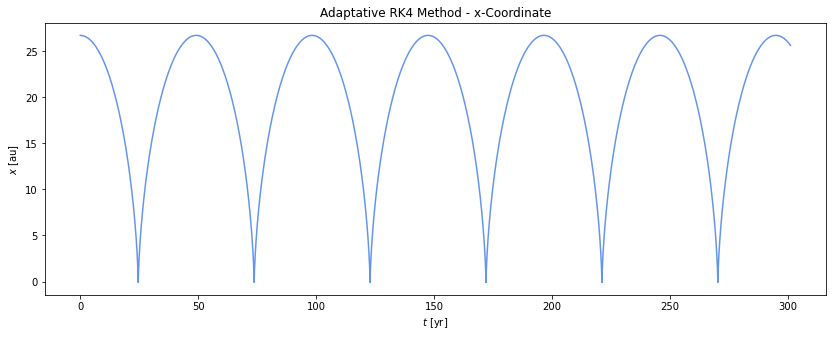

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(14,5))
ax.plot(Q[:,0], Q[:,1], color='cornflowerblue')
ax.set_title('Adaptative RK4 Method - x-Coordinate')
ax.set_xlabel(r'$t$ [yr]')
ax.set_ylabel(r'$x$ [au]')
#ax.legend()

plt.show()

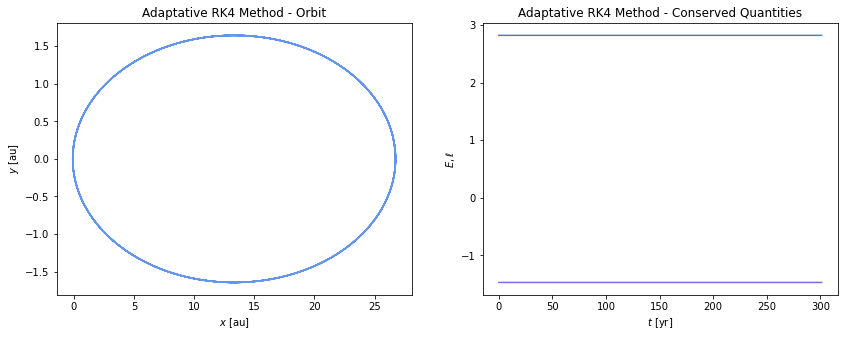

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].plot(Q[:,1], Q[:,2], color='cornflowerblue')#, label=f'$dt=$ {dt:.2e} yr')
ax[0].set_title('Adaptative RK4 Method - Orbit')
ax[0].set_xlabel(r'$x$ [au]')
ax[0].set_ylabel(r'$y$ [au]')
#ax[0].legend()

ax[1].plot(conservedQuantities[:,0], conservedQuantities[:,1], color='mediumslateblue', label=f'Energy')
ax[1].plot(conservedQuantities[:,0], conservedQuantities[:,2], color='steelblue', label=f'Angular Momentum')
ax[1].set_title('Adaptative RK4 Method - Conserved Quantities')
ax[1].set_xlabel(r'$t$ [yr]')
ax[1].set_ylabel(r'$E, \ell$')
#ax[1].legend()

plt.show()

In [6]:
print('El cambio en energía es :', np.abs(conservedQuantities[-1,1] - conservedQuantities[0,1]))
print('\nEl cambio en momento angular es :', np.abs(conservedQuantities[-1,2] - conservedQuantities[0,2]))

El cambio en energía es : 8.053647575501088e-07

El cambio en momento angular es : 5.766116029093382e-09


---

Visualizamos la coordenada x mostrando los tiempos en los cuales se calculo la función. Nótese que en efecto el paso de integración cambia, haciendose más corto en la región del perihelio y mas grande en el afelio.

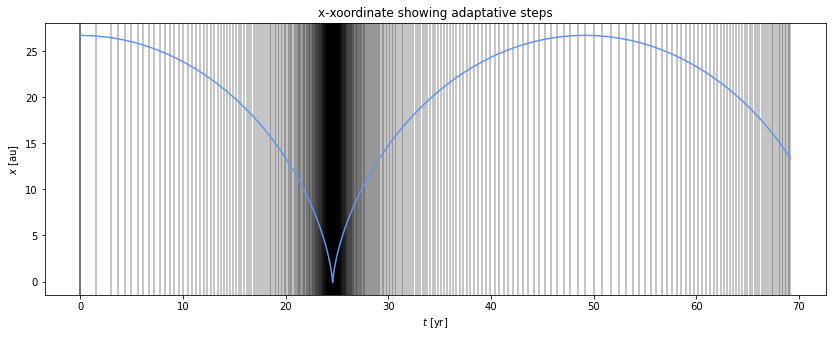

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(14,5))
for i in range(1000):
    ax.axvline(Q[i,0], color='black', alpha=0.3)
ax.plot(Q[:1000,0], Q[:1000,1], color='cornflowerblue')
ax.set_title('x-xoordinate showing adaptative steps')
ax.set_xlabel(r'$t$ [yr]')
ax.set_ylabel(r'$x$ [au]')
#ax.legend()

plt.show()

In [64]:
# Save data of the orbit
#np.savetxt('comet_orbit.txt', Q, header='t x y vx vy')